In [1]:
import os
import json
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

from time import time

import torch
from torch.utils.data import DataLoader

baseDir = '/home/hoehlein/PycharmProjects/grib_windfields'
os.chdir(baseDir)

from GUI.GraphCreator import createVectorGraph
from DataPreprocessing.DataScaler import DataScaler
from DataPreprocessing import DataLoader as dl
from Networks.CondVAE import *
from Utils.PlotsCondVAE import FieldViewer

In [2]:
netName = 'CE_VGG+CD_UNet'
runNumber = 28
epoch = 50

runName = 'run_{:05d}'.format(runNumber)

encName, decName = netName.split('+')

runDir = '{}/results/{}/records/{}'.format(baseDir, netName, runName)

with open(os.path.join(runDir, 'config.json'), 'r') as f:
    configOptions = json.load(f)
    
configOptions['training'].update({'batchSize': 10})

logDir = configOptions['debugging']['recordDir']
directories = {'results': os.path.join(logDir, netName),
               'records': os.path.join(logDir, netName, 'records'),
               'models':  os.path.join(logDir, netName, 'records', 'models'),
               'data': {'training': configOptions['preprocess']['pathTraining'],
                        'test':     configOptions['preprocess']['pathTest'],
                        'raw':      configOptions['preprocess']['pathRaw']}
              }
directories.update({'currentRun': os.path.join(directories['records'], runName)})
directories.update({'models': os.path.join(directories['currentRun'], 'models')})
    
dataOpt = dl.dataSettings('input', 'input_orography', configOptions['data']['gridsInput'],
                          'target', 'target_orography', configOptions['data']['gridsTarget'])

valiOpt = dl.validationSettings(configOptions['data']['validationMode'],
                                configOptions['data']['validationInput'],
                                configOptions['data']['validationRegions'])

patchMode = configOptions['preprocess']['patchSize'] if configOptions['preprocess']['patching'] else None
trainingOpt = dl.trainingSettings(configOptions['preprocess']['monthsTraining'],
                                  patchMode, configOptions['data']['useHROrography'],
                                  configOptions['preprocess']['trainingRegions'])

# set up scaling for variable transformation
scalerUV = DataScaler(mode='normalize_neg')
scalerLSM = DataScaler(mode='normalize_neg')
scalerBLH = DataScaler(mode='normalize_neg')
scalerFSR = DataScaler(mode='normalize_neg')
scalerZ = DataScaler(mode='normalize_neg')
scalerZOro = DataScaler(mode='normalize_neg')
scalerLSMOro = DataScaler(mode='normalize_neg')
# quantizerUV = Quantizer(num_bins=100)

print(os.getcwd())

scaleDict = torch.load(os.path.join(directories['models'], 'scaling.pth'))
scaleOpt = dl.scalingSettings(*[scaleDict[key] for key in scaleDict.keys()])


dataLoader = dl.DataLoader(directories['data']['training'],
                           configOptions['data']['maxNumFiles'],
                           dataOpt, trainingOpt, scaleOpt, valiOpt)
dataTraining, dataValidation = dataLoader.loadDataForTraining()

# create loaders for PyTorch with pre-defined batch size
trainLoader = DataLoader(dataTraining, batch_size=configOptions['training']['batchSize'],
                         shuffle=True, drop_last=True, num_workers=0)
validationLoader = DataLoader(dataValidation, batch_size=configOptions['training']['batchSize'],
                              shuffle=False, drop_last=True, num_workers=0)

net = torch.load(os.path.join(directories['models'], 'CondVAE_epoch_{}.pth'.format(epoch)))['model']

/home/hoehlein/PycharmProjects/grib_windfields
[INFO]: Process data file <data/training/alps/ERA5_predictand_vars_area1_2017_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8767)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8767/8767)
[INFO]: Process data file <data/training/alps/ERA5_predictand_vars_area1_2018_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8760)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8760/8760)
[INFO]: Process data file <data/training/alps/HRES_100m_wind_cpts_area1_2017_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8767)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8767/8767)
[INFO]: Process data file <data/training/alps/HRES_100m_wind_cpts_area1_2018_packed_padded.npz>
[INFO]: Load used grids into RAM
Progress: |=========>....................| 34% (3000/8760)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |==============================| 100% (8760/8760)
48.738083362579346
[INFO]: Normalize input and output channels
[INFO]: Create training and validation data
[INFO]: Number of training files: 8760
[INFO]: Number of validation files: 8760


In [3]:
dataBatch = next(iter(validationLoader))
inputs_cpu, targets_cpu, gridLR, gridHR, maskLR, maskHR, hrOro, idx = dataBatch

# gridLR = gridLR.data.numpy()
# gridLR = gridLR[0]
# gridHR = gridHR.data.numpy()
# gridHR = gridHR[0]

# maskLR = maskLR.data.numpy()
# maskLR = maskLR[0]
# maskHR = maskHR.data.numpy()
# maskHR = maskHR[0]

# targets_np = targets_cpu.data.numpy() # remember batch size dimension

cudaAvailable = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaAvailable else "cpu")
net.to(device)

conditions = inputs_cpu.to(device)
targets = targets_cpu.to(device)

net.eval()

CondVAE(
  (encoder): CE_VGG(
    (inputLR): Sequential(
      (0): Sequential(
        (0): ReflectionPad2d((2, 2, 2, 2))
        (1): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1))
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.05, inplace=True)
        (4): Dropout2d(p=0.1, inplace=False)
      )
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.05, inplace=True)
      )
    )
    (inputHR): Sequential(
      (0): Sequential(
        (0): ReflectionPad2d((2, 2, 2, 2))
        (1): Conv2d(2, 32, kernel_size=(5, 5), stride=(2, 3))
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.05, inplace=True)
        (4)

In [4]:
results_mu = []
results_mu_latent = []
results_logVar = []
results_logVar_latent = []
results_z = []
for i in range(200):
    with torch.no_grad():
        rec, mu, logVar, z = net(targets, conditions)
        rec_mu, rec_logVar = rec
        rec_mu = rec_mu.cpu().data.numpy()
        rec_logVar = rec_logVar.cpu().data.numpy()
        results_mu += [rec_mu[0]]
        results_logVar += [rec_logVar[0]]
        mu = mu.cpu().data.numpy()
        results_mu_latent += [mu[0]]
        logVar = logVar.cpu().data.numpy()
        results_logVar_latent += [logVar[0]]
        z = z.cpu().data.numpy()
        results_z += [z[0]]
results_mu = np.array(results_mu)
results_mu_latent = np.array(results_mu_latent)
results_logVar = np.array(results_logVar)
results_logVar_latent = np.array(results_logVar_latent)

currPath = os.getcwd()
os.chdir('./Jupyter')
t = int(time())
folderName = '{}_{}_{}_rec'.format(runNumber, epoch, t) 
os.mkdir(folderName)
os.chdir(folderName)
print(folderName)
np.save('gridLR.npy', gridLR.data.cpu().numpy())
np.save('gridHR.npy', gridHR.data.cpu().numpy())
np.save('maskLR.npy', maskLR.data.cpu().numpy())
np.save('maskHR.npy', maskHR.data.cpu().numpy())
np.save('targets.npy', targets_cpu.data.cpu().numpy())
np.save('inputs.npy', inputs_cpu.data.cpu().numpy())
np.save('mu.npy', results_mu)
np.save('muLatent.npy', results_mu_latent)
np.save('logVar.npy', results_logVar)
np.save('logVarLatent.npy', results_logVar_latent)
os.chdir(currPath)

/home/hoehlein/anaconda3/envs/pytorch_networks/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


28_50_1574778110_rec


In [5]:
results_mu = []
results_z = []
results_logVar = []
for i in range(200):
    with torch.no_grad():
        mu, logVar, z = net.decoder.sample(conditions[0:1], samples=1)
        mu = mu.cpu().data.numpy()
        logVar = logVar.cpu().data.numpy()
        z = z.cpu().data.numpy()
        results_mu += [mu[0]]
        results_logVar += [logVar[0]]
        results_z += [z[0]]
results_mu = np.array(results_mu).squeeze()
results_z = np.array(results_mu_latent)
results_logVar = np.array(results_logVar).squeeze()
print(results_mu.shape, results_logVar.shape, results_z.shape)
currPath = os.getcwd()
os.chdir('./Jupyter')
# t = int(time())
folderName = '{}_{}_{}_smp'.format(runNumber, epoch, t) 
os.mkdir(folderName)
os.chdir(folderName)
print(folderName)
np.save('gridLR.npy', gridLR.data.cpu().numpy())
np.save('gridHR.npy', gridHR.data.cpu().numpy())
np.save('maskLR.npy', maskLR.data.cpu().numpy())
np.save('maskHR.npy', maskHR.data.cpu().numpy())
np.save('targets.npy', targets_cpu.data.cpu().numpy())
np.save('inputs.npy', inputs_cpu.data.cpu().numpy())
np.save('mu.npy', results_mu)
np.save('z.npy', results_z)
np.save('logVar.npy', results_logVar)
os.chdir(currPath)

(200, 2, 144, 180) (200, 2, 144, 180) (200, 12, 3, 5)
28_50_1574778110_smp


In [6]:
var_mu_latent = np.var(results_mu_latent, axis=0)
var_logVar_latent = np.var(results_logVar_latent, axis=0)
print(var_mu_latent.flatten())
print(var_logVar_latent.flatten())

[4.9960036e-16 4.9960036e-16 1.0116907e-14 3.1225023e-17 5.5511151e-15
 3.4694470e-16 0.0000000e+00 4.3910188e-18 5.5511151e-17 3.4694470e-16
 3.4694470e-14 1.0880186e-14 1.0495077e-16 4.9960036e-16 1.4658413e-16
 1.1510792e-12 5.5511151e-15 3.5527137e-13 2.5668356e-13 8.8817842e-12
 1.4551915e-11 4.6043169e-12 4.6984638e-13 5.6843419e-14 3.5527137e-15
 1.7408297e-13 5.6843419e-12 2.1684043e-15 3.8689052e-12 3.1974423e-12
 7.8062556e-16 2.1684043e-15 5.2770288e-15 2.2204460e-16 3.4694470e-18
 4.4964032e-15 5.0098814e-15 2.8102520e-16 2.2204460e-16 2.1684043e-17
 1.3877788e-17 5.8633653e-16 4.1980308e-16 1.1241008e-15 1.2490009e-14
 6.8001160e-16 3.5527137e-15 6.7168493e-15 2.7200464e-15 3.4694470e-16
 7.9936058e-15 1.3877788e-17 7.8279397e-17 1.7000290e-16 3.1225023e-15
 4.9960036e-16 2.2903771e-18 5.5511151e-17 1.4658413e-16 3.1225023e-15
 1.0625181e-15 8.3353463e-16 2.2204460e-16 6.8001160e-16 4.2500725e-17
 1.0625181e-15 4.9960036e-16 1.2490009e-16 2.2204460e-16 1.6792123e-15
 1.333

In [7]:
print(np.exp(results_logVar_latent[0].flatten()))

[0.8266805  0.7974029  0.7949924  0.85839903 0.87993956 0.91020215
 0.8444783  0.8465284  0.86126375 0.8830484  0.76953846 0.79228836
 0.8555162  0.8620316  0.90960443 0.03350557 0.03255416 0.02627842
 0.01923505 0.01975031 0.01992268 0.03131919 0.02718273 0.01931161
 0.01908852 0.01876675 0.03119018 0.03802086 0.02910208 0.01997743
 0.83031535 0.86807466 0.92833835 0.91038823 0.91276455 0.83165854
 0.8569732  0.9147767  0.92368746 0.9170996  0.837747   0.8136137
 0.9014986  0.95517915 0.8934383  0.9633059  0.91981274 0.8549334
 0.8604432  0.8892729  0.9376072  0.9179562  0.93830276 0.8205113
 0.8539485  0.9096649  0.9062323  0.9149192  0.8099406  0.8408724
 1.1930102  1.1621236  1.0797526  0.8724738  1.0420572  0.93444306
 1.0043076  0.93523616 0.9267814  0.8798679  1.2837675  1.2115945
 0.9839555  0.90140945 0.8202605  0.01978678 0.01910087 0.01304719
 0.00691473 0.01086409 0.00785705 0.01385407 0.01059661 0.00869252
 0.0076334  0.01304203 0.02191808 0.01646071 0.0125725  0.00894708


Sum of squared entries:  44.69533


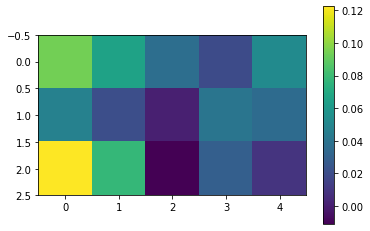

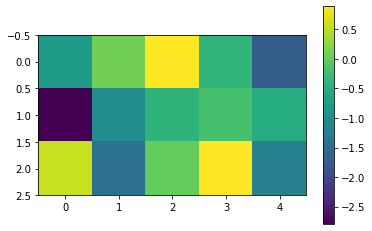

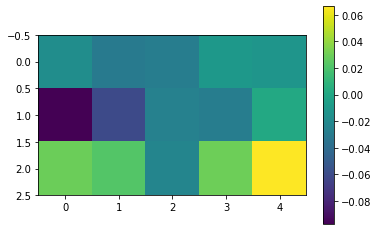

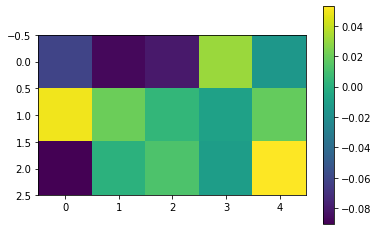

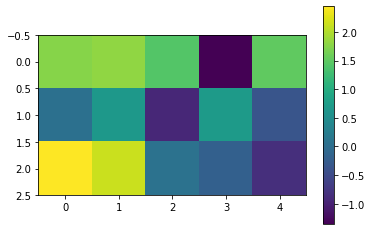

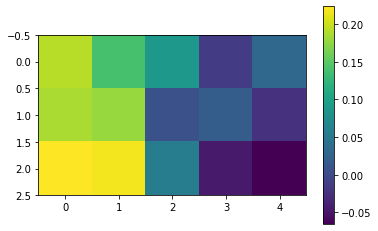

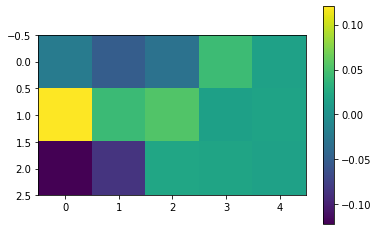

In [8]:
for i in range(results_mu_latent.shape[1]):
    plt.figure()
    plt.imshow(results_mu_latent[0,i])
    plt.colorbar()
print('Sum of squared entries: ', np.sum(results_mu_latent[0]**2))

In [9]:
numSamples = 20000
samples = []
for sample in range(numSamples):
    a = np.random.randn(*results_mu_latent[0].shape)
    if sample == 0:
        print(a.shape)
    samples += [np.sum(a**2)]

(12, 3, 5)


(array([8.800e+01, 1.102e+03, 4.197e+03, 6.823e+03, 5.119e+03, 2.079e+03,
        5.050e+02, 7.500e+01, 9.000e+00, 3.000e+00]),
 array([118.29882593, 134.83977418, 151.38072243, 167.92167068,
        184.46261893, 201.00356718, 217.54451543, 234.08546368,
        250.62641193, 267.16736018, 283.70830843]),
 <a list of 10 Patch objects>)

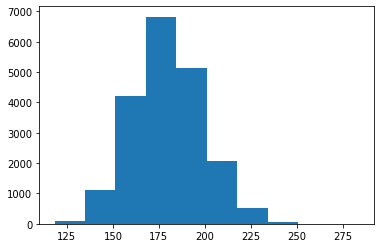

In [10]:
plt.hist(samples)

In [13]:
mu_torch = results_mu_latent[0]
mu_torch = torch.Tensor(mu_torch).view(1,1,*mu_torch.shape)
mu_torch = mu_torch.to(device)
print(mu_torch.size())

torch.Size([1, 1, 12, 3, 5])


In [11]:
fvLR = FieldViewer(gridLR, maskLR)
fvHR = FieldViewer(gridHR, maskHR)

In [12]:
condition = conditions[0].view(1, -1, 36, 60)
target = targets[0].view(1, -1, 144, 180)
mu_latent, logVar_latent, z_latent = net.encoder(target, condition, samples=1)
print(mu_latent.size())
print(z_latent.size())
rec_mu_mean, rec_logVar_mean = net.decoder(torch.unsqueeze(mu_latent,0), condition)
rec_mu_z, rec_logVar_z = net.decoder(z_latent, condition)
rec_mu_random, rec_logVar_random = net.decoder(torch.randn_like(z_latent), condition) 
fig = plt.figure(figsize=(10,8))
fvHR.plot_glyphs(data=rec_mu_mean, scale=2000, color_by='norm')
fig = plt.figure(figsize=(10,8))
fvHR.plot_glyphs(data=rec_mu_z, scale=2000, color_by='norm')
fig = plt.figure(figsize=(10,8))
fvHR.plot_glyphs(data=rec_mu_random, scale=2000, color_by='norm')

torch.Size([1, 12, 3, 5])
torch.Size([1, 1, 12, 3, 5])
[INFO] Processing 4D data array.
[INFO] Found padded vector field.
[INFO] Processing 4D data array.
[INFO] Found padded vector field.
[INFO] Processing 4D data array.
[INFO] Found padded vector field.


In [23]:
numSamples = 200
samples = []
for sample in range(numSamples):
    rec_mu_random, rec_logVar_random = net.decoder(torch.randn_like(z_latent), condition) 
    samples += [rec_mu_random[0].data.cpu().numpy()] 
#     fig = plt.figure(figsize=(10,8))
#     fvHR.plot_glyphs(data=rec_mu_random, scale=2000, color_by='norm')
samples = np.array(samples)

[INFO] Processing 4D data array.
[INFO] Found padded vector field.
[INFO] Processing 4D data array.
[INFO] Found padded vector field.
[INFO] Processing 4D data array.
[INFO] Found padded vector field.
[INFO] Processing 4D data array.
[INFO] Found padded vector field.


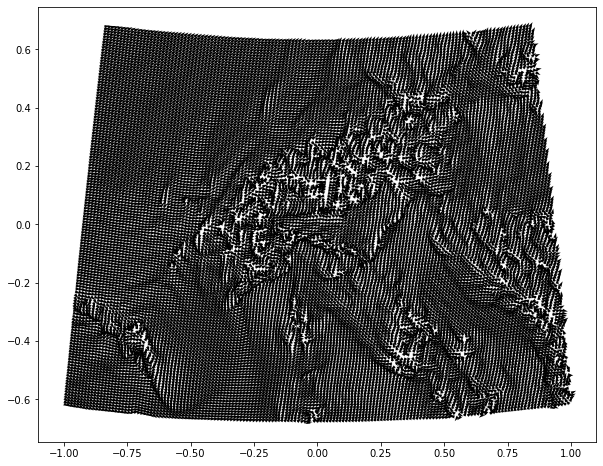

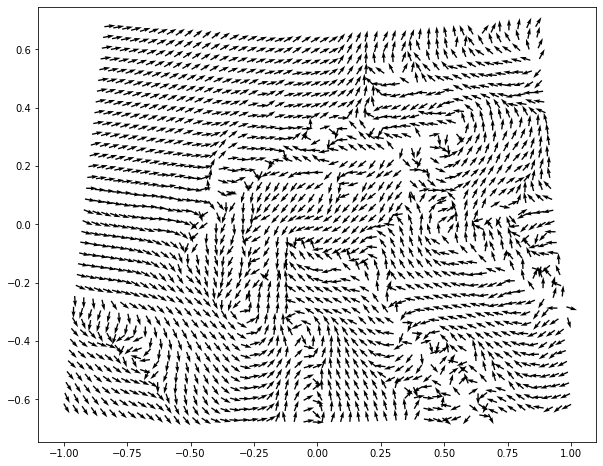

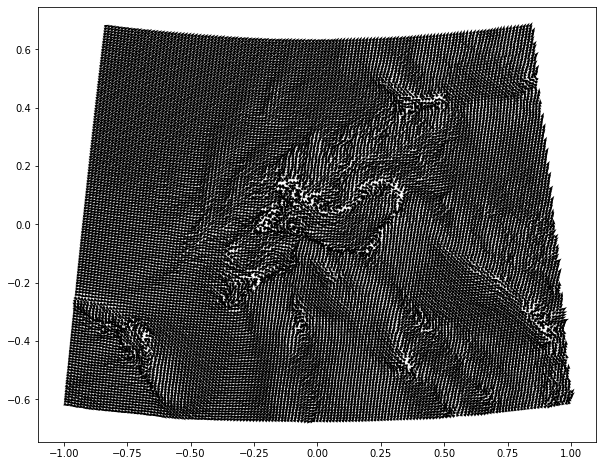

In [58]:
numSamples = 2
# samples = []
target_cpu = target.cpu().data.numpy()
fig = plt.figure(figsize=(10,8))
fvHR.plot_glyphs(data=target_cpu/np.linalg.norm(target_cpu, axis=1, keepdims=True),
                 scale=100)
input_cpu = condition[:,0:2].cpu().data.numpy()
fig = plt.figure(figsize=(10,8))
fvLR.plot_glyphs(data=input_cpu/np.linalg.norm(input_cpu, axis=1, keepdims=True),
                 scale=50)
for sample in range(numSamples):
    rec_mu_random, rec_logVar_random = net.decoder(torch.randn_like(z_latent), condition) 
    rec_mu_random = rec_mu_random.cpu().data.numpy()
    rec_logVar_random = rec_logVar_random.cpu().data.numpy()
    vecfield = rec_mu_random + np.random.rand(*rec_mu_random.shape)*np.exp(rec_logVar_random/2)
#    samples += [rec_mu_random[0].data.cpu().numpy()] 
    fig = plt.figure(figsize=(10,8))
#     fvHR.plot_glyphs(data=rec_mu_random, scale=1000, color_by='norm', cmap='plasma')
    fvHR.plot_glyphs(data=vecfield/np.linalg.norm(vecfield, axis=1, keepdims=True),
                     scale=100)


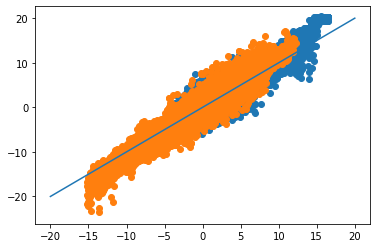

In [16]:
plt.scatter(rec_mu_mean[0,0].cpu().data.numpy().flatten(),
           target[0,0].cpu().data.numpy().flatten())
plt.scatter(rec_mu_mean[0,1].cpu().data.numpy().flatten(),
           target[0,1].cpu().data.numpy().flatten())
plt.plot([-20, 20], [-20,20])

In [24]:
samples.shape

(200, 2, 144, 180)

In [39]:
sample_mean = np.mean(samples, axis=0, keepdims=True)
sample_var = np.var(samples, axis=0, keepdims=True)

[INFO] Processing 4D data array.
[INFO] Found padded scalar field.


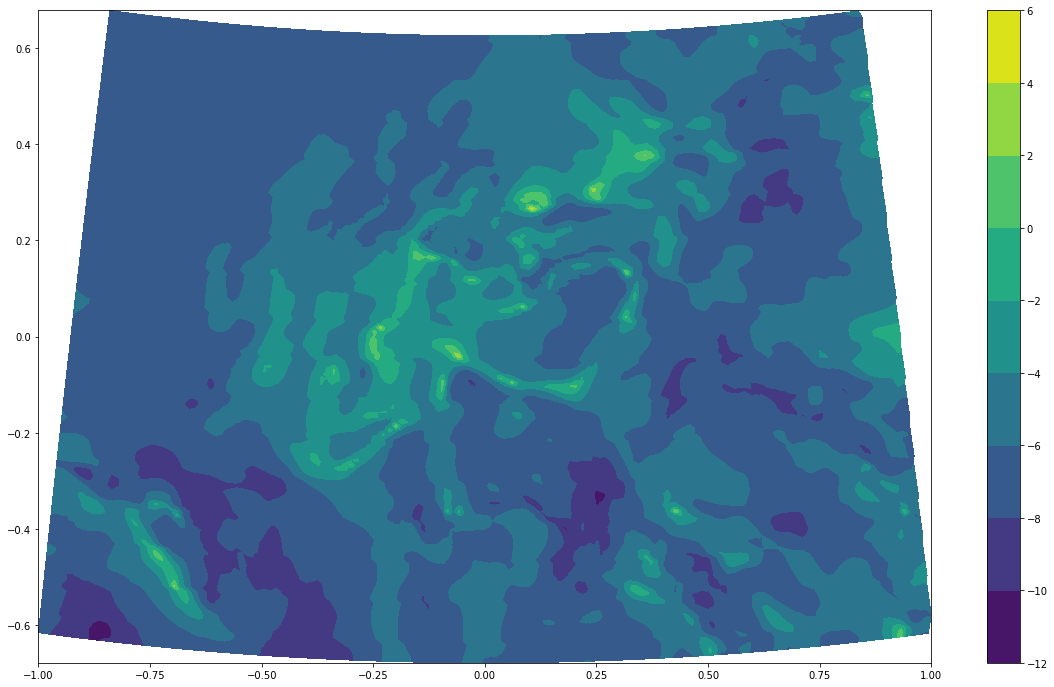

In [40]:
plt.figure(figsize=(20,12))
fvHR.plot_scalar(data = np.log(var[:, 0:1 ,:,:]/norm_sample_mean**2), cbar=True)


In [31]:
sample_var.shape
sample_mean.shape

(1, 2, 144, 180)

In [33]:
norm_sample_mean = np.linalg.norm(sample_mean, axis=1, keepdims=True)